<a href="https://colab.research.google.com/github/LucaM185/MLgit/blob/main/TransformerMultiHead.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -O dataset.txt https://www.gutenberg.org/cache/epub/11/pg11.txt


--2023-11-22 23:10:58--  https://www.gutenberg.org/cache/epub/11/pg11.txt
Resolving www.gutenberg.org (www.gutenberg.org)... 152.19.134.47, 2610:28:3090:3000:0:bad:cafe:47
Connecting to www.gutenberg.org (www.gutenberg.org)|152.19.134.47|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 174392 (170K) [text/plain]
Saving to: ‘dataset.txt’

dataset.txt         100%[===================>] 170.30K   699KB/s    in 0.2s    

2023-11-22 23:10:58 (699 KB/s) - ‘dataset.txt’ saved [174392/174392]



In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [3]:
with open("dataset.txt", "r") as f:
    text = f.read()
print(text[:300])

﻿The Project Gutenberg eBook of Alice's Adventures in Wonderland
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project G


In [4]:
texttoint = {elm: n for n, elm in enumerate(set(text))}
inttotext = {n:elm for n, elm in enumerate(set(text))}
dataset = [texttoint[c] for c in text]
device = torch.device("cpu")

sequence_length = 16
X = [dataset[i:i+sequence_length+1] for i in range(len(dataset)-sequence_length-1)]
X = torch.tensor(X).to(device)
y = X[:, -1]
X = X[:, :-1]

In [48]:
class Model(nn.Module):
    def __init__(self):
        super().__init__()

        self.vocab_size = X.max() + 1

        self.head_size = 25
        self.emb_size = 25

        self.pemb = nn.Embedding(sequence_length, self.emb_size)
        self.wemb = nn.Embedding(self.vocab_size, self.emb_size)

        self.keys = nn.Linear(self.emb_size, self.head_size)
        self.queries = nn.Linear(self.emb_size, self.head_size)
        self.values = nn.Linear(self.emb_size, self.head_size)

        self.fc1 = nn.Linear(sequence_length*self.head_size, 200)
        self.LayerNorm1 = nn.LayerNorm(200)
        self.fc2 = nn.Linear(200, 200)
        self.LayerNorm2 = nn.LayerNorm(200)
        self.out = nn.Linear(200, self.vocab_size)


    def forward(self, data):  # inputs: [Batch_size, time, vocab_size]
        batch = data.shape[0]

        # embeddings
        pemb = self.pemb(torch.arange(sequence_length)).view(1, sequence_length, self.emb_size) # [time, emb_size]
        wemb = self.wemb(data)        # [Batch_size, time, emb_size]

        embeddings = wemb + pemb

        # attention
        k = self.keys(embeddings)     # [Batch_size, time, head_size]
        q = self.queries(embeddings)  # [Batch_size, time, head_size]
        v = self.values(embeddings)   # [Batch_size, time, head_size]

        similarity = k @ q.transpose(-2, -1)/(self.head_size**0.5)
        similarity = torch.tril(similarity)  # [Batch_size, time, time]
        similarity[similarity == 0] = float("-inf")
        similarity = torch.softmax(similarity, dim = 1)
        attention = similarity @ v    # [Batch_size, time, head_size]

        # linear
        x = attention.view(batch, sequence_length*self.head_size)

        x = F.gelu(self.fc1(x))
        x = self.LayerNorm1(x)
        x = F.gelu(self.fc2(x))
        x = self.LayerNorm2(x)
        x = self.out(x)

        return x


Net = Model().to(device)
lossi = []
print("Millions of parameters: ", round(sum(p.numel() for p in Net.parameters() if p.requires_grad)/1000000, 2))

Millions of parameters:  0.14


In [34]:
epochs = 10000
batch_size = 64
print("Percent of dataset: ", epochs*batch_size / X.shape[0])

optimizer = torch.optim.Adam(Net.parameters(), lr=3e-4)

for epoch in range(epochs):
    indexes = torch.randint(X.shape[0], (batch_size, ))

    pred = Net(X[indexes])
    loss = F.cross_entropy(pred, y[indexes])
    lossi.append(loss.item())

    loss.backward()
    optimizer.step()
    optimizer.zero_grad()


Percent of dataset:  3.9040339650954965


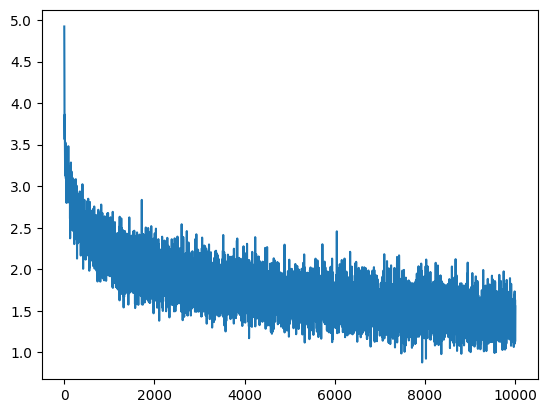

In [35]:
plt.plot(lossi)

In [36]:
torch.tensor(lossi[-100:]).mean() # Best: 1.54 / 1.66

tensor(1.4213)

In [37]:
# LAYERNORM IS CRAZY IMPORTANT

In [38]:
prompt = "hi, how are you? I'm fine, "

for i in range(100):
    ints = torch.tensor([texttoint[elm] for elm in prompt[-sequence_length:]])
    prompt += inttotext[Net(ints.view(1, -1)).argmax().item()]

In [39]:
prompt

"hi, how are you? I'm fine, I should be and the the to the court, and the thing to herself and the the to the court, and the thi"